In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [14]:
# 1 year before the latest date
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

sel = [Measurement.date, 
       Measurement.prcp]
filtered = session.query(*sel).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all()

# Calculate the date 1 year ago from today
year_ago = dt.date.today() - dt.timedelta(days=365)
year_ago

datetime.date(2017, 9, 8)

In [16]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(filtered, columns=['date','prcp'])
df.set_index('date', inplace=True, )
df.sort_values(by=['date'])
df.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


<IPython.core.display.Javascript object>


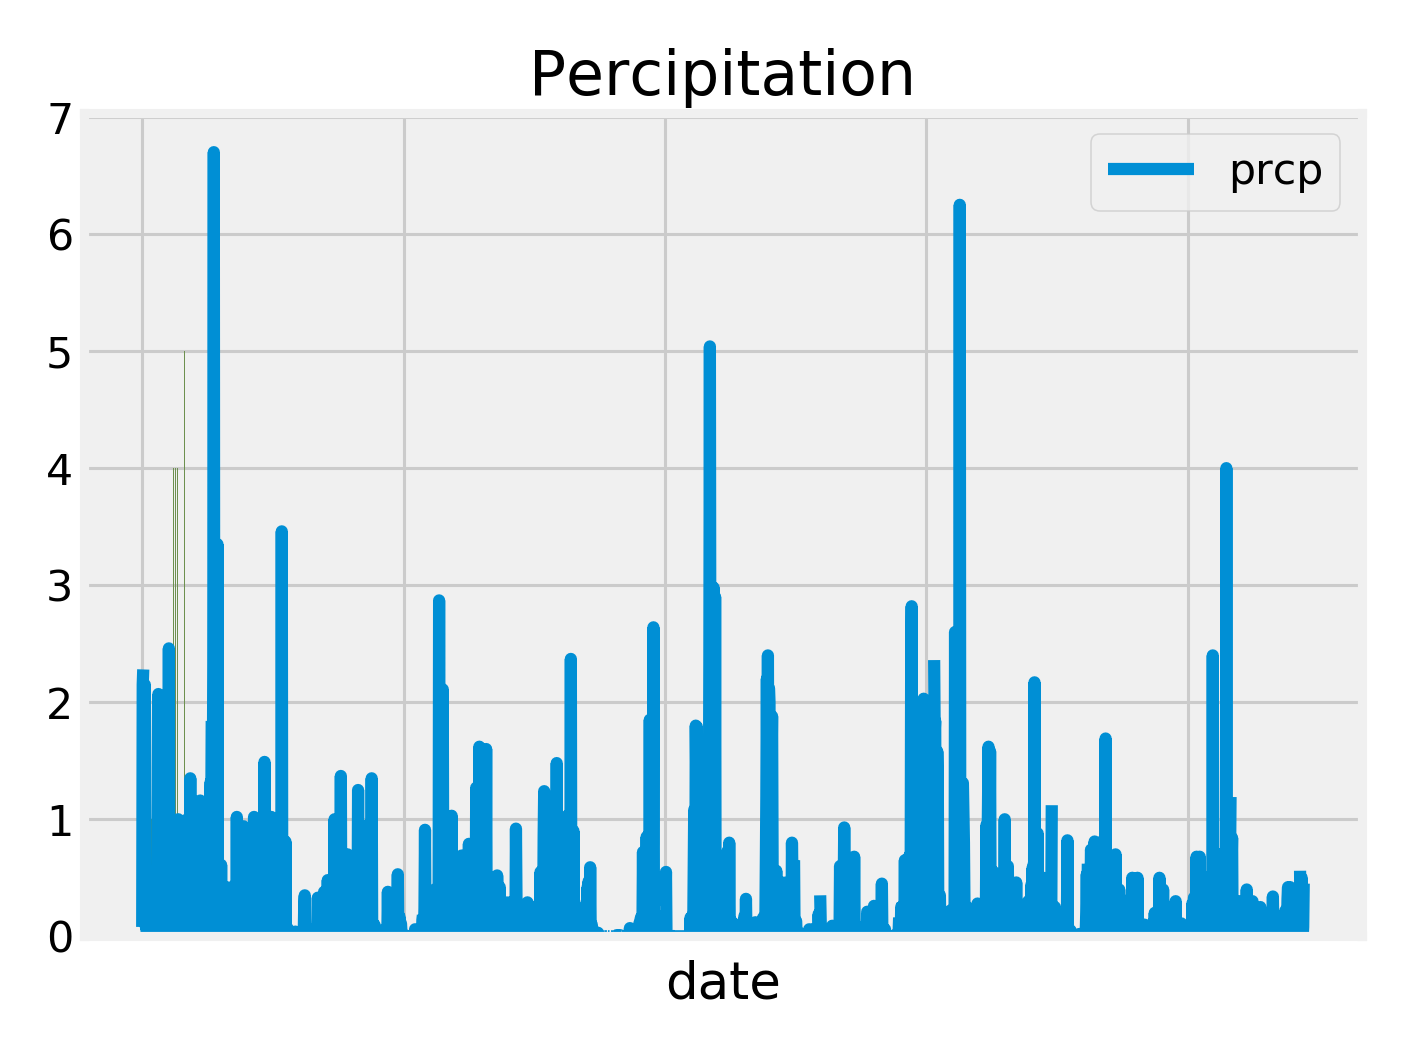

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

df.plot(title="Percipitation")
plt.tight_layout()
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# How many stations are available in this dataset?

session.query(func.count(Station.station)).all()

[(9)]

In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.

sel2 = [Measurement.station,
       func.count(Measurement.station)]
Active = session.query(*sel2).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
Active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel3 = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
Maxmin = session.query(*sel3).all()
Maxmin

[(53.0, 87.0, 73.09795396419437)]

In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel4 = [Measurement.tobs,
       func.count(Measurement.tobs)]
Highest = session.query(*sel4).group_by(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date > '2016-08-23').all()
Highest

[(59.0, 3),
 (60.0, 2),
 (61.0, 1),
 (62.0, 6),
 (63.0, 4),
 (64.0, 3),
 (65.0, 7),
 (66.0, 5),
 (67.0, 15),
 (68.0, 12),
 (69.0, 19),
 (70.0, 22),
 (71.0, 18),
 (72.0, 22),
 (73.0, 18),
 (74.0, 39),
 (75.0, 33),
 (76.0, 33),
 (77.0, 30),
 (78.0, 22),
 (79.0, 18),
 (80.0, 11),
 (81.0, 4),
 (82.0, 3),
 (83.0, 1)]

<IPython.core.display.Javascript object>


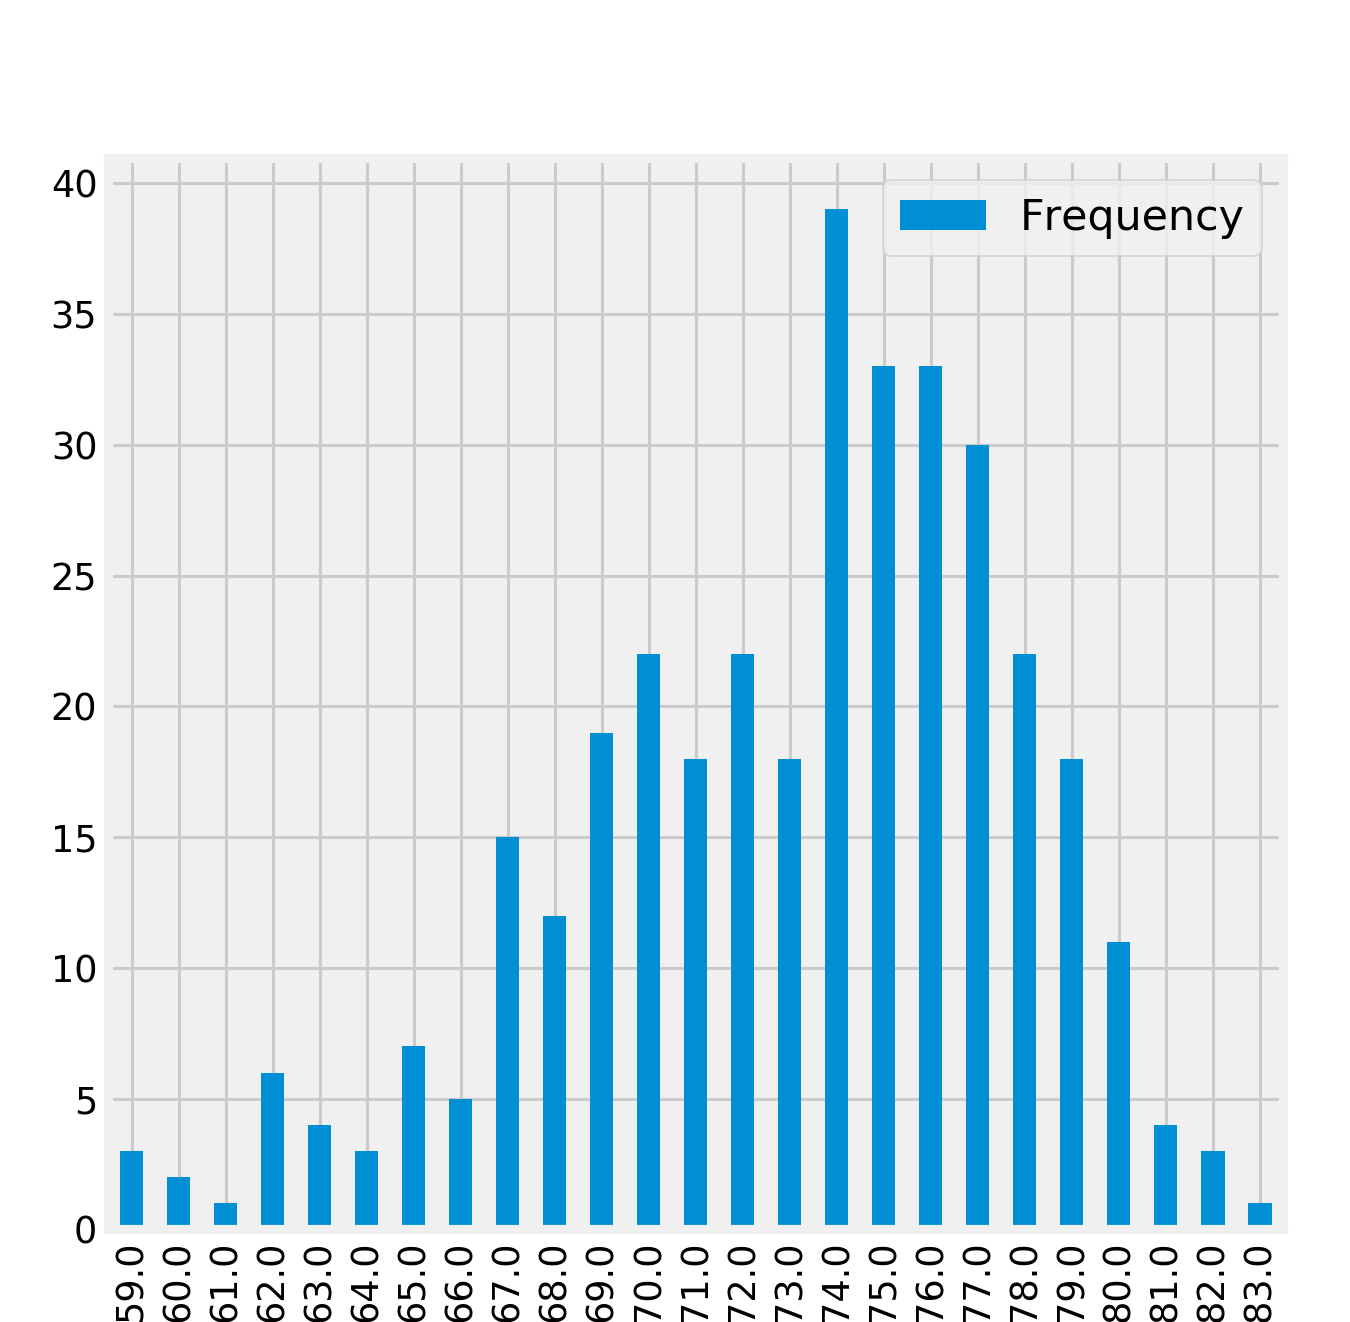

In [47]:
df2 = pd.DataFrame(Highest, columns=['Temperature','Frequency'])
df2 = df2.set_index('Temperature')
ax = df2.plot.bar(fontsize=12)
plt.show()

In [41]:
df2.head()

,Frequency
Temperature,
59.0,3
60.0,2
61.0,1
62.0,6
63.0,4


In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]
